In [33]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Function to calculate EVI with handling for saturated areas and NoData
def calculate_evi(nir, red, blue, nir_nodata, red_nodata, blue_nodata):
    G = 2.5
    C1 = 6.0
    C2 = 7.5
    L = 1.0

    # Create a mask for NoData values
    mask = (nir != nir_nodata) & (red != red_nodata) & (blue != blue_nodata)

   # Cap NIR values to avoid saturation (e.g., NIR saturation threshold)
    nir_cap = np.percentile(nir[mask], 99)  # Cap NIR at the 99th percentile to avoid extreme saturation
    nir_capped = np.clip(nir, 0, nir_cap)  # Clip NIR to this threshold
    
    # Avoid division by zero by adding a small constant (epsilon)
    denominator = (nir_capped + C1 * red - C2 * blue + L)
    denominator[denominator == 0] = epsilon  # Replace zero denominator to avoid division by zero

    # Calculate EVI
    evi = G * ((nir_capped - red) / denominator)

    # Apply mask to EVI to remove values from NoData pixels
    evi[~mask] = np.nan  # Set EVI to NaN where the mask is False

    return evi


In [35]:
# Load Sentinel-2 Bands (assuming they are in GeoTIFF format)
def load_band(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).astype('float32'), src.nodata  # Also return NoData value


In [36]:
# Save calculated EVI as GeoTIFF
def save_to_geotiff(output_path, data, reference_path):
    with rasterio.open(reference_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data, 1)

In [37]:
# Set file paths for the necessary bands (update these with your actual file paths)
red_band_path = 'F:/FOREST INVENTORY CLASSIFICATION/2020/L2A_Au20_04.TIF'   # Red (Band 4)
blue_band_path = 'F:/FOREST INVENTORY CLASSIFICATION/2020/L2A_Au20_02.TIF'  # Blue (Band 2)
nir_band_path = 'F:/FOREST INVENTORY CLASSIFICATION/2020/L2A_Au20_8A.TIF'   # NIR (Band 8)

In [38]:
# Load bands and their NoData values
red, red_nodata = load_band(red_band_path)
blue, blue_nodata = load_band(blue_band_path)
nir, nir_nodata = load_band(nir_band_path)

In [39]:
# Small constant to avoid division by zero
epsilon = 1e-10

In [40]:
# Calculate EVI with additional handling for dense forest saturation
evi = calculate_evi(nir, red, blue, nir_nodata, red_nodata, blue_nodata)

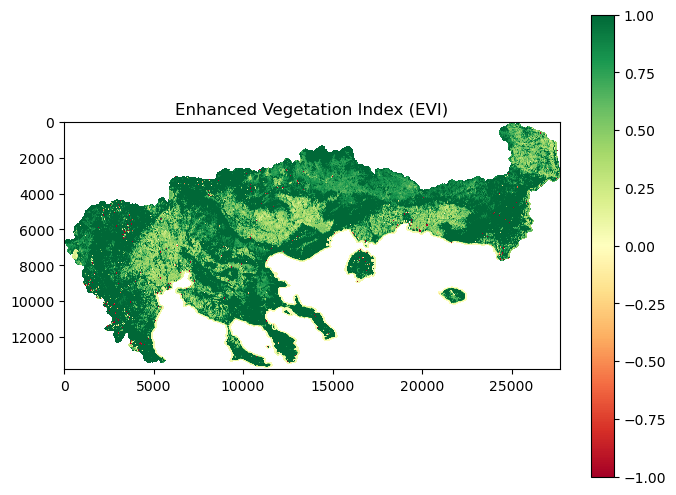

In [41]:
# Plot EVI
plt.figure(figsize=(8, 6))
plt.imshow(evi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Enhanced Vegetation Index (EVI)')
plt.show()

In [42]:
# Save the EVI result as a GeoTIFF file
save_to_geotiff('evi_index.tif', evi, nir_band_path)

print("EVI has been calculated and saved as a GeoTIFF file.")

EVI has been calculated and saved as a GeoTIFF file.
